### RNN with Attention (Possible solution)

In [ ]:
# -*- coding: utf-8 -*-
"""
Wind Turbine Power Prediction with RNNs + Attention

This lab uses an Attention-enhanced Recurrent Neural Network to predict wind turbine power output.
"""

# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Step 1: Prepare the Data
# Load the dataset
df = pd.read_csv('T1.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Convert Date/Time to proper datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')
print(f"Date range: {df['Date/Time'].min()} to {df['Date/Time'].max()}")

# Check for missing values and handle them
missing_values = df.isnull().sum()
print(f"\nMissing values:\n{missing_values}")

# Basic exploratory analysis
print(df.describe())

Dataset shape: (50530, 5)
Columns: ['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
Date range: 2018-01-01 00:00:00 to 2018-12-31 23:50:00

Missing values:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64
                           Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
mean   2018-07-01 20:01:30.065307648          1307.684332          7.557952   
min              2018-01-01 00:00:00            -2.471405          0.000000   
25%              2018-04-03 05:22:30            50.677890          4.201395   
50%              2018-06-30 16:15:00           825.838074          7.104594   
75%              2018-09-26 18:57:30          2482.507568         10.300020   
max              2018-12-31 23:50:00    

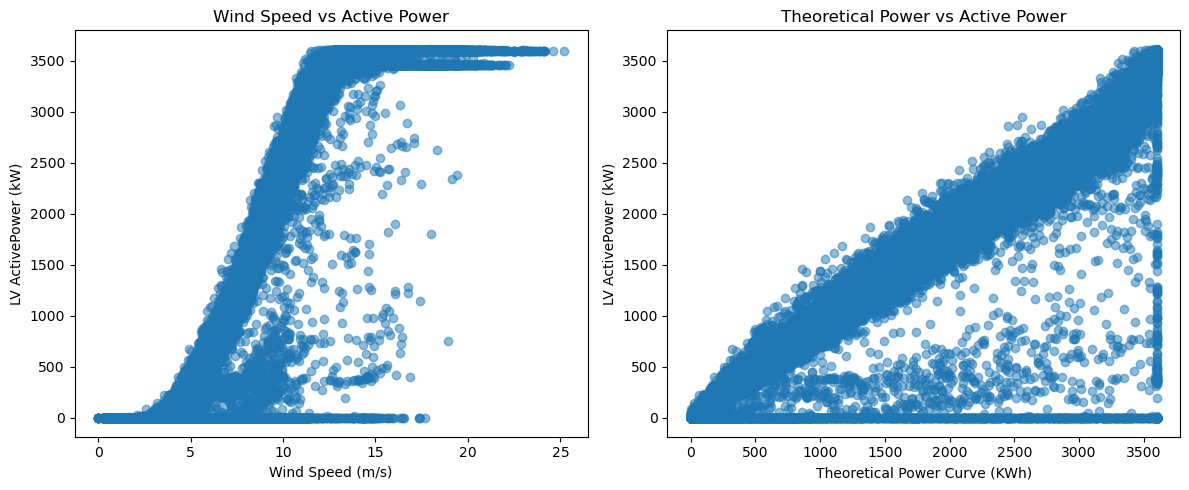

In [3]:
# Create scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Wind Speed vs Active Power
axes[0].scatter(df['Wind Speed (m/s)'], df['LV ActivePower (kW)'], alpha=0.5)
axes[0].set_xlabel('Wind Speed (m/s)')
axes[0].set_ylabel('LV ActivePower (kW)')
axes[0].set_title('Wind Speed vs Active Power')

# Theoretical Power vs Active Power
axes[1].scatter(df['Theoretical_Power_Curve (KWh)'], df['LV ActivePower (kW)'], alpha=0.5)
axes[1].set_xlabel('Theoretical Power Curve (KWh)')
axes[1].set_ylabel('LV ActivePower (kW)')
axes[1].set_title('Theoretical Power vs Active Power')

plt.tight_layout()
plt.show()


In [4]:
# Select relevant features
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']
data = df[features].values

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [5]:
# Step 2: Create sequences
def create_sequences(data, window_size):
    """
    Create sequences for RNN input.
    
    Args:
        data: Normalized data array
        window_size: Number of time steps in each sequence
    
    Returns:
        X: Input sequences (samples, time steps, features)
        y: Target values (next LV ActivePower value)
    """
    X, y = [], []
    
    for i in range(window_size, len(data)):
        # Input: window of all features
        X.append(data[i-window_size:i])
        # Output: next LV ActivePower value (index 0)
        y.append(data[i, 0])
    
    return np.array(X), np.array(y)

# Create sequences with window size of 24
window_size = 24
X, y = create_sequences(scaled_data, window_size)

print(X.shape)
print(y.shape)

(50506, 24, 3)
(50506,)


In [6]:
# Step 3: Split the data
# 80/20 train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (40404, 24, 3), y_train: (40404,)
X_test: (10102, 24, 3), y_test: (10102,)


In [7]:
# Step 4: Define a Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, hidden_dim)
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        # Compute alignment scores
        # x shape: (batch_size, time_steps, hidden_dim)
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        # e shape: (batch_size, time_steps, 1)
        
        # Compute attention weights
        a = tf.nn.softmax(e, axis=1)
        
        # Compute context vector
        context = x * a
        context = tf.reduce_sum(context, axis=1)
        
        return context, a
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [8]:
# Step 5: Build the RNN Model with Attention
# Define input shape
n_features = X_train.shape[2]
n_steps = X_train.shape[1]

# Build model using Functional API
inputs = Input(shape=(n_steps, n_features))

# LSTM layers with return_sequences=True
lstm_out = LSTM(64, return_sequences=True)(inputs)
lstm_out = Dropout(0.2)(lstm_out)
lstm_out = LSTM(32, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

# Attention layer
context, attention_weights = AttentionLayer()(lstm_out)

# Output layer
outputs = Dense(1)(context)

# Create model
model = Model(inputs=inputs, outputs=outputs)

In [9]:
# Step 6: Compile and Train the Model
# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
print("\nModel Summary:")
model.summary()

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ [(None, 32), (None,    │            56 │
│ (AttentionLayer)                │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,913 (116.85 KB)

 Trainable params: 29,913 (116.85 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0292 - mae: 0.1129 - val_loss: 0.0082 - val_mae: 0.0632
Epoch 2/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0112 - mae: 0.0674 - val_loss: 0.0050 - val_mae: 0.0467
Epoch 3/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0076 - mae: 0.0550 - val_loss: 0.0044 - val_mae: 0.0416
Epoch 4/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0066 - mae: 0.0503 - val_loss: 0.0042 - val_mae: 0.0417
Epoch 5/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0062 - mae: 0.0480 - val_loss: 0.0042 - val_mae: 0.0415
Epoch 6/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0060 - mae: 0.0472 - val_loss: 0.0043 - val_mae: 0.0427
Epoch 7/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0058 - mae: 0.0461 - val_loss: 0.0043 - val_mae: 0.0430
Epoch 8/50
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0056 - mae: 0.0453 - val_loss: 0.0042 - val_mae: 0.0405
Epoch 9/50
1011/1011 ━━━━━━━━━━━━━━━━━━━

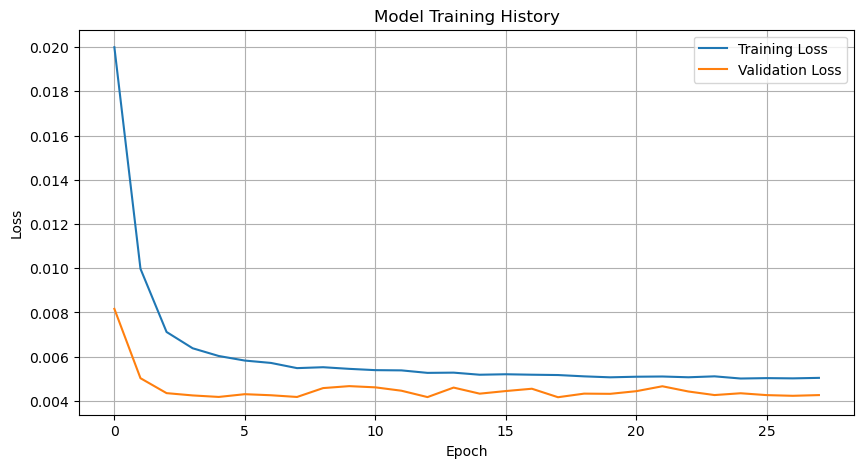

In [10]:

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Step 7: Evaluate Results
# Generate predictions
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

# Create arrays for inverse transformation
# We need to create full arrays with all features to inverse transform correctly
n_features_original = len(features)
y_test_full = np.zeros((len(y_test), n_features_original))
y_pred_full = np.zeros((len(y_pred), n_features_original))

# Place predictions in the first column (LV ActivePower position)
y_test_full[:, 0] = y_test
y_pred_full[:, 0] = y_pred

# Inverse transform to original scale
y_test_original = scaler.inverse_transform(y_test_full)[:, 0]
y_pred_original = scaler.inverse_transform(y_pred_full)[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Model Performance:
MSE: 53579.4514
RMSE: 231.4724
R²: 0.9702


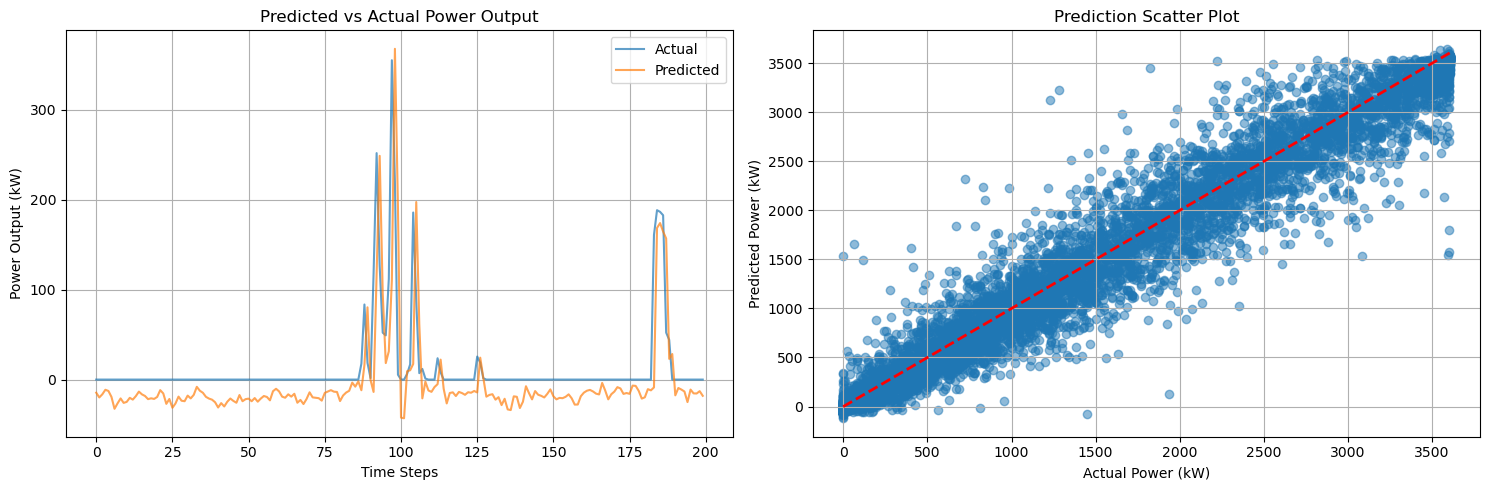

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


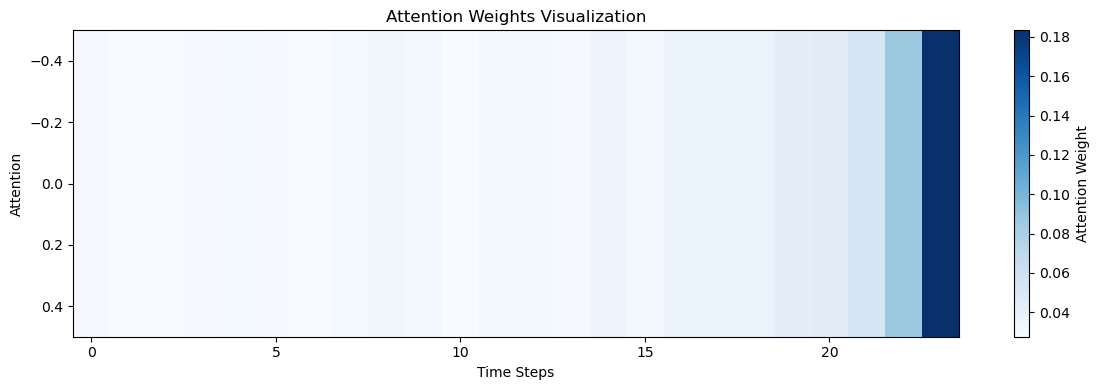


Attention weights shape: (1, 24, 1)
Most influential time steps: [23 22 21 20 19]


In [12]:
# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Time series plot
axes[0].plot(y_test_original[:200], label='Actual', alpha=0.7)
axes[0].plot(y_pred_original[:200], label='Predicted', alpha=0.7)
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Power Output (kW)')
axes[0].set_title('Predicted vs Actual Power Output')
axes[0].legend()
axes[0].grid(True)

# Scatter plot
axes[1].scatter(y_test_original, y_pred_original, alpha=0.5)
axes[1].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', lw=2)
axes[1].set_xlabel('Actual Power (kW)')
axes[1].set_ylabel('Predicted Power (kW)')
axes[1].set_title('Prediction Scatter Plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Visualize attention weights for a sample
# Create a model to extract attention weights
attention_model = Model(inputs=model.input, 
                       outputs=model.get_layer('attention_layer').output[1])

# Get attention weights for a sample
sample_idx = 0
sample_input = X_test[sample_idx:sample_idx+1]
sample_attention = attention_model.predict(sample_input)

# Plot attention weights
plt.figure(figsize=(12, 4))
plt.imshow(sample_attention[0].T, cmap='Blues', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Time Steps')
plt.ylabel('Attention')
plt.title('Attention Weights Visualization')
plt.tight_layout()
plt.show()

print("\nAttention weights shape:", sample_attention.shape)
print("Most influential time steps:", np.argsort(sample_attention[0].flatten())[-5:][::-1])